In [ ]:
import numpy as np
import os
import cv2
import pandas as pd
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
#Switching to GPU memory

import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    # Allow GPU memory growth, adjust as needed
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16869143140499256622
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14048821248
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12252452053563622814
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4080, pci bus id: 0000:01:00.0, compute capability: 8.9"
]


### Importing the data, make sure that the labels correspond with the images

In [3]:
def load_images_and_labels(folder_path, csv_file_path):
    # Read the CSV file into a pandas DataFrame
    images_df = pd.read_csv(csv_file_path)

    # Get a list of all files in the folder
    files = os.listdir(folder_path)

    # Filter the files to include only image files (you can customize the extensions)
    image_files = [file for file in files if file.lower().endswith(('.png'))]

    image_label_mapping = dict(zip(images_df['Image'], images_df['Class']))

    # Lists to store images and corresponding labels
    images = []
    labels = []

    # Loop through the image files
    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)

        try:
            # Check if the image file name is in the mapping
            if image_file in image_label_mapping:
                # Read the image using OpenCV
                img = cv2.imread(image_path)

                # Append the image and label to the lists
                images.append(img)
                labels.append(image_label_mapping[image_file])
            else:
                print(f"No label found for {image_file}")

        except Exception as e:
            print(f"Error opening {image_path}: {e}")

    return images, labels


In [4]:
train_images, train_labels = load_images_and_labels("train_images", "./train.csv")

In [5]:
val_images, val_labels = load_images_and_labels("val_images", "./val.csv")

In [6]:
print(len(train_images))
print(len(train_labels))
print(len(val_images))
print(len(val_labels))

13000
13000
2000
2000


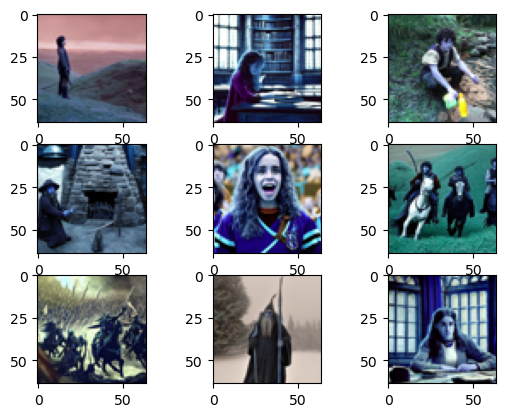

0
47
25
18
7
26
22
17
10


In [7]:
#Displaying some of the imported pictures
import matplotlib.pyplot as plt
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(train_images[i])
# show the figure
plt.show()

for i in range(9):
    print(train_labels[i])

### Prepare the data


In [8]:
#One hot encoded
train_labels = to_categorical(train_labels, 100)
val_labels = to_categorical(val_labels, 100)
print("y_train[0] one hot: ", train_labels[0])

y_train[0] one hot:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [9]:
def prepare_data(train, val):
    # Convert lists to NumPy arrays
    train = np.array(train, dtype='float32')
    val = np.array(val, dtype='float32')

    # Normalize to range [0.0, 1.0]
    train /= 255.0  # Assuming your data range is [0, 255]
    val /= 255.0   # Assuming your data range is [0, 255]

    # Return the normalized images
    return train, val

# Assuming train_images and val_images are lists
train_images, val_images = prepare_data(train_images, val_images)


### Building the model

In [11]:
#48% pe eval Model from first laboratory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout

def build_model():
    model = Sequential()
    
    # add the layers

    model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu', input_shape=(64,64,3)))
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(64, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Dropout(0.25))
    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))
    
    model.add(Dropout(0.5))

    model.add(Dense(100, activation='softmax'))

    return model

model = build_model()

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, ReLU, DepthwiseConv2D, GlobalAveragePooling2D, Input
import numpy as np
from tensorflow.keras import backend


def mini_mobileNet():
    model = Sequential()

    # Initial Convolutional Layer
    model.add(Conv2D(32, 3, strides=(2, 2), padding='same', use_bias=False, input_shape=(64, 64, 3)))
    model.add(BatchNormalization())
    model.add(ReLU())

    # Depthwise Separable Convolution Blocks
    model.add(DepthwiseConv2D(3, strides=(1, 1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(64, 1, use_bias=False))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(DepthwiseConv2D(3, strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(128, 1, use_bias=False))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(DepthwiseConv2D(3, strides=(1, 1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(128, 1, use_bias=False))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(DepthwiseConv2D(3, strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(256, 1, use_bias=False))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(DepthwiseConv2D(3, strides=(1, 1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(256, 1, use_bias=False))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(DepthwiseConv2D(3, strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(512, 1, use_bias=False))
    model.add(BatchNormalization())
    model.add(ReLU())

    # Repeat Blocks
    for _ in range(5):
        model.add(DepthwiseConv2D(3, strides=(1, 1), padding='same', use_bias=False))
        model.add(BatchNormalization())
        model.add(ReLU())
        model.add(Conv2D(512, 1, use_bias=False))
        model.add(BatchNormalization())
        model.add(ReLU())

        model.add(DepthwiseConv2D(3, strides=(2, 2), padding='same', use_bias=False))
        model.add(BatchNormalization())
        model.add(ReLU())
        model.add(Conv2D(1024, 1, use_bias=False))
        model.add(BatchNormalization())
        model.add(ReLU())

        model.add(DepthwiseConv2D(3, strides=(1, 1), padding='same', use_bias=False))
        model.add(BatchNormalization())
        model.add(ReLU())
        model.add(Conv2D(1024, 1, use_bias=False))
        model.add(BatchNormalization())
        model.add(ReLU())

    # Global Average Pooling and Dense Layer
    model.add(GlobalAveragePooling2D())
    model.add(Dense(100, activation='softmax'))

    return model

model = mini_mobileNet()


In [10]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense
from tensorflow.keras.layers import AvgPool2D, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, concatenate
import tensorflow.keras.backend as K

def densenet(input_shape = (64, 64, 3), n_classes = 100, filters = 32):
    
    #batch norm + relu + conv
    def bn_rl_conv(x,filters,kernel=1,strides=1):
        
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(filters, kernel, strides=strides,padding = 'same')(x)
        return x
    
    def dense_block(x, repetition):
        
        for _ in range(repetition):
            y = bn_rl_conv(x, 4*filters)
            y = bn_rl_conv(y, filters, 3)
            x = concatenate([y,x])
        return x
        
    def transition_layer(x):
        
        x = bn_rl_conv(x, K.int_shape(x)[-1] //2 )
        x = AvgPool2D(2, strides = 2, padding = 'same')(x)
        return x
    
    input = Input (input_shape)
    x = Conv2D(64, 7, strides = 2, padding = 'same')(input)
    x = MaxPool2D(3, strides = 2, padding = 'same')(x)
    
    for repetition in [6, 12, 24, 16]:
        
        d = dense_block(x, repetition)
        x = transition_layer(d)
    x = GlobalAveragePooling2D()(d)
    output = Dense(n_classes, activation = 'softmax')(x)
    
    model = Model(input, output)
    return model

model = densenet()


### Compile the model


In [12]:
#model.load_weights('mobileNet_63.h5')

In [12]:
optimizer = Adam(learning_rate = 0.001)

optimizer2 = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.7, nesterov=True, decay=0.01/40)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])



### Train the model

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


checkpoint_filepath = 'best_model_weights.h5'
early_stopping_filepath = 'early_stopping.h5'   

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_freq='epoch',  # Save weights every epoch
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',  # Choose the metric to monitor (e.g., val_accuracy)
    mode='max',               # 'max' for accuracy, 'min' for loss, 'auto' will infer from the metric name
    patience=20,                # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored metric
    verbose=1
)

datagen = ImageDataGenerator(
    rotation_range=2,          # Degree range for random rotations
    width_shift_range=0.2,      # Fraction of total width for random horizontal shift
    height_shift_range=0.2,     # Fraction of total height for random vertical shift
    shear_range=0.2,            # Shear intensity (shear angle in radians)
    zoom_range=0.2,             # Range for random zoom
    horizontal_flip=True,       # Randomly flip images horizontally
    fill_mode='nearest'         # Points outside the boundaries are filled according to the given mode
)


def lr_schedule(epoch):
    initial_lr = 0.01
    if epoch < 50:
        return initial_lr
    elif epoch < 100:
        return 0.001
    else:
        return 0.0005

lr_scheduler = LearningRateScheduler(lr_schedule)


In [14]:
### Train the model
history = model.fit(
    datagen.flow(train_images, train_labels, batch_size=32),
    epochs=150,
    validation_data=(val_images, val_labels),
    callbacks=[model_checkpoint_callback, lr_scheduler, early_stopping_callback],
    shuffle=True
)

Epoch 1/150
407/407 [==============================] - 11s 17ms/step - loss: 4.7331 - accuracy: 0.0085 - val_loss: 4.6066 - val_accuracy: 0.0100

Epoch 00001: val_accuracy improved from -inf to 0.01000, saving model to best_model_weights.h5
Epoch 2/150
407/407 [==============================] - 6s 15ms/step - loss: 4.6118 - accuracy: 0.0084 - val_loss: 4.6067 - val_accuracy: 0.0100

Epoch 00002: val_accuracy did not improve from 0.01000
Epoch 3/150
177/407 [============>.................] - ETA: 3s - loss: 4.6103 - accuracy: 0.0090

KeyboardInterrupt: 

In [19]:
model.save_weights('mobileNet_63.h5')

### Make predictions

In [58]:
def load_images_in_order(image_folder_path, csv_file_path):
    # Read the CSV file into a pandas DataFrame
    images_df = pd.read_csv(csv_file_path)

    # Extract the 'Image' column from the DataFrame
    image_names = images_df['Image'].tolist()

    # Create paths to the images based on the folder path
    image_paths = [os.path.join(image_folder_path, image_name) for image_name in image_names]

    # Lists to store images and corresponding labels
    images = []
    labels = []

    # Loop through the image files
    for image_path in image_paths:
        try:
            # Read the image using OpenCV
            img = cv2.imread(image_path)

            # Append the image to the list
            images.append(img)

            # No label is available, you can set it to None or any default value
            labels.append(None)

        except Exception as e:
            print(f"Error opening {image_path}: {e}")

    return images, labels

test_images, test_labels = load_images_in_order("test_images", "./test.csv")

In [59]:
test_images = np.array(test_images, dtype='float32')
test_images /= 255.0 

In [60]:
def predict():
    # 7.1. (re)build the model
    model_re = densenet()
    
    # 7.2. load the model's saved weights.
    model_re.load_weights('DenseNet_74.h5')

    # 7.3. Predict the class of the first 10 images in the test set
    predictions = model_re.predict(test_images)
    
    # 7.4. Print the predictions done by the model ([7, 2, 1, 0, 4])
    print("Predictions: \n", np.argmax(predictions, axis=1))

    return np.argmax(predictions, axis=1)
    
predictions = predict()

Predictions: 
 [67 91 40 ... 94 15 65]


In [61]:
print(predictions)
print(predictions.shape)

[67 91 40 ... 94 15 65]
(5000,)


### Export the predictions

In [62]:
import pandas as pd

# Read the image names from the CSV file
image_names_df = pd.read_csv("./test.csv")

# Extract the 'Image' column from the DataFrame
image_names = image_names_df['Image'].tolist()

# Create a DataFrame with 'Image' and 'Class' columns
df = pd.DataFrame({'Image': image_names, 'Class': predictions})

# Export the DataFrame to a CSV file
df.to_csv('eval74.csv', index=False)

print("CSV file 'predictions.csv' has been created.")


CSV file 'predictions.csv' has been created.


### Leaning Curves and Data interpretations

In [23]:
train_accuracy = history.history['accuracy']
train_loss = history.history['loss']
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(val_accuracy) + 1  # Add 1 because epochs start from 1

# Print the best results
print(f"Best Results:\nEpoch: {best_epoch}\n"
      f"Training Accuracy: {train_accuracy[best_epoch - 1]:.4f}\n"
      f"Training Loss: {train_loss[best_epoch - 1]:.4f}\n"
      f"Validation Accuracy: {val_accuracy[best_epoch - 1]:.4f}\n"
      f"Validation Loss: {val_loss[best_epoch - 1]:.4f}")


Best Results:
Epoch: 52
Training Accuracy: 0.7035
Training Loss: 0.9507
Validation Accuracy: 0.7110
Validation Loss: 28.4649


Training History:
{'loss': [2.9441773891448975, 2.26643443107605, 2.053044557571411, 1.9000234603881836, 1.8256819248199463, 1.7573915719985962, 1.6830683946609497, 1.6318575143814087, 1.6083117723464966, 1.5591068267822266, 1.5329307317733765, 1.494495153427124, 1.4489063024520874, 1.4280177354812622, 1.404248833656311, 1.4051624536514282, 1.353916049003601, 1.3518166542053223, 1.3026673793792725, 1.3200618028640747, 1.2704410552978516, 1.2641907930374146, 1.230741262435913, 1.2165950536727905, 1.2171164751052856, 1.1987489461898804, 1.204978108406067, 1.1662204265594482, 1.1534252166748047, 1.1430127620697021, 1.1087397336959839, 1.1291050910949707, 1.0959800481796265, 1.088660478591919, 1.0625699758529663, 1.068522334098816, 1.0433754920959473, 1.0395867824554443, 1.0302863121032715, 1.0014482736587524, 0.989075243473053, 0.9820773601531982, 0.9877829551696777, 0.9956917762756348, 0.9632952809333801, 0.9551147818565369, 0.9240766167640686, 0.9348173141479492, 0.9171226620674133, 0.9

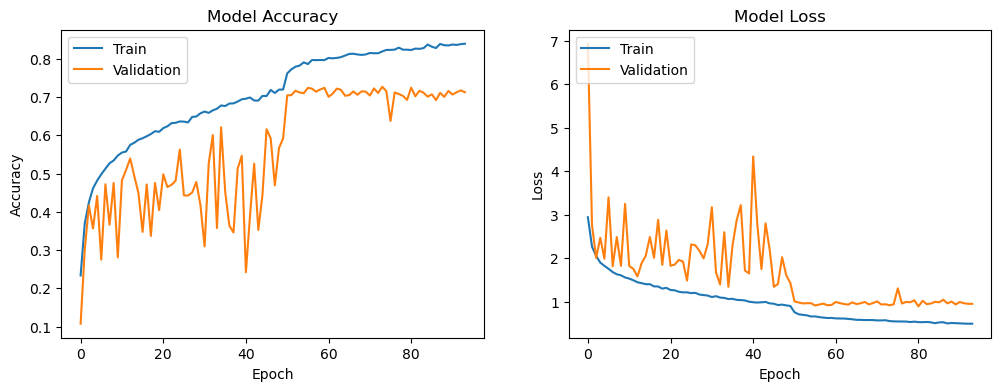

In [21]:
# Print training history
print("Training History:")
print(history.history)

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Example confusion matrix
# Replace this with your actual confusion matrix

model_val = RNN_model()
    
    # 7.2. load the model's saved weights.
model_val.load_weights('RNN.h5')

    # 7.3. Predict the class of the first 10 images in the test set
valPredictions = model_val.predict(val_images)
    
    # 7.4. Print the predictions done by the model ([7, 2, 1, 0, 4])
print("Predictions: \n", np.argmax(valPredictions, axis=1))

true_labels = np.argmax(val_labels, axis=1)
predicted_labels = np.argmax(valPredictions, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)


Predictions: 
 [61 77 77 ... 77 77 77]


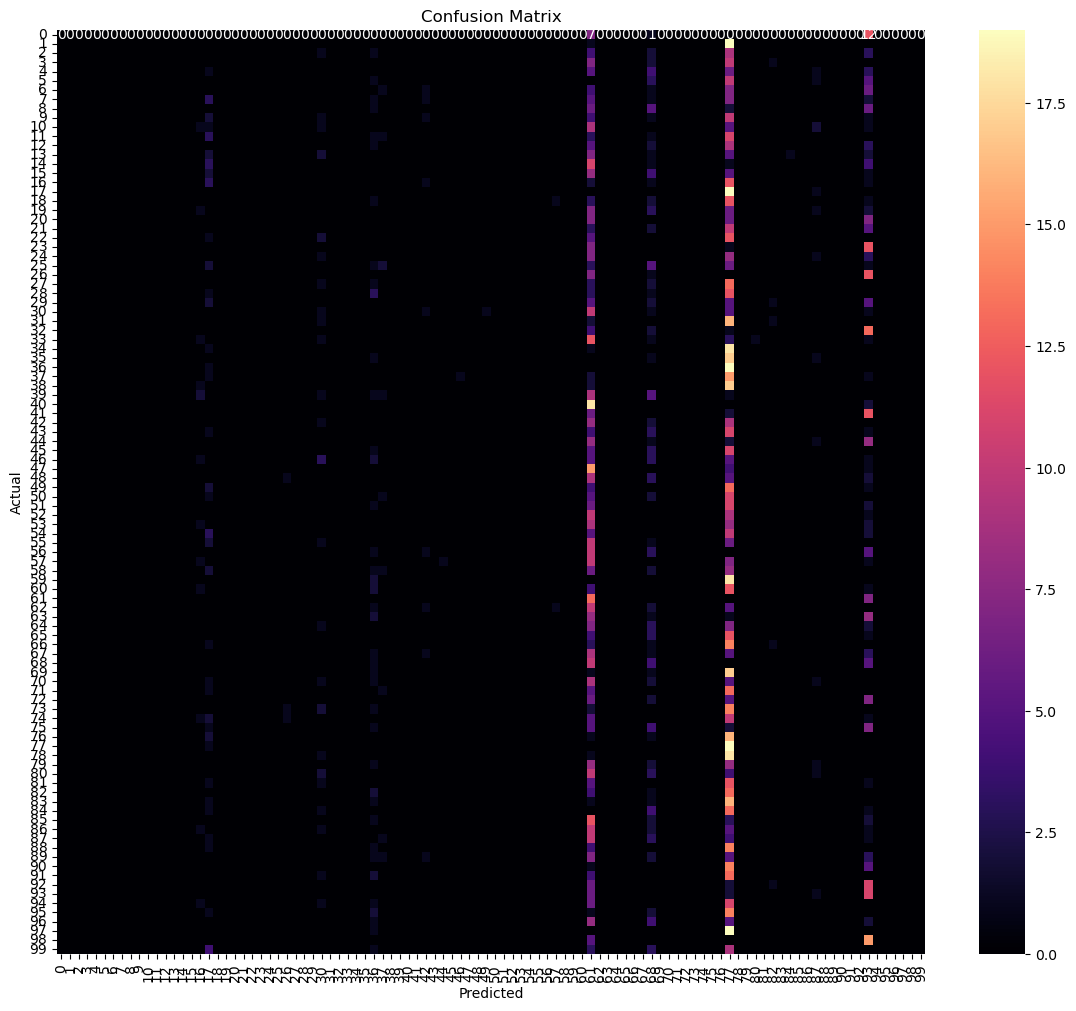

In [22]:
# Plot the confusion matrix with color
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt="d", cmap="magma", cbar=True,
            xticklabels=np.unique(true_labels), yticklabels=np.unique(true_labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()